# Analysis of the EGRT data
I will only do this exemplary and very short.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
import math
from sklearn.metrics import r2_score

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, read_pickle, write_pickle, create_mask_egrt
%load_ext autoreload
%autoreload 2

######## Input #####
plot_save=True #True False
path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
#####################

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
#my output
# Some Version information of the imported packages
# pandas version: 1.3.4
# pickle version: 4.0

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [2]:
# import solexperts data
# 20s
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename=r"\alle Messungen_TEMP.txt"

#encoding= 'unicode_escape': for reading non asci characters
temp_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0, encoding= 'unicode_escape')
temp_sol.index.names = ["Length [m]"]
temp_sol.index = temp_sol.index.astype(int)
temp_sol.columns.names = ["Date"]
temp_sol.columns= pd.to_datetime(temp_sol.columns)
temp_sol = temp_sol.T

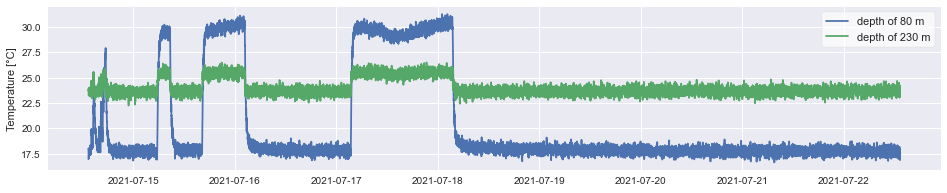

In [3]:
# Plot all temperatures during EGRT
# Input
depth1=230
depth2=80

offset=511
cable_length1=offset+depth1
cable_length2=offset+depth2

dat1=temp_sol[cable_length1]
dat2=temp_sol[cable_length2]

fig,axs = plt.subplots(1,1,figsize=(16,3))
axs.plot(dat2.index, dat2.values, label=f"depth of {depth2} m")
axs.plot(dat1.index, dat1.values, label=f"depth of {depth1} m")



legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)
axs.set_ylabel("Temperature [°C]")
if plot_save:
    filename=f"\\egrt_temperatures_overview"
    plt.savefig(r"pictures"+filename + ".png")
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap3" +filename + ".pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap3" +filename + ".png", format="png",bbox_inches="tight",dpi=300)
plt.show()

# ungestörte Temperatur bei 100 m depth 18 °C

# Thermnal conductivity calculation

C:\Users\Mathis\AppData\Local\Temp/ipykernel_6564/3142828149.py:22: RuntimeWarning: invalid value encountered in log
  x=np.log(t/(t-t_duration_heating))
C:\Users\Mathis\AppData\Local\Temp/ipykernel_6564/3142828149.py:23: RuntimeWarning: invalid value encountered in log
  x_30afterheatstop=np.log(t_30afterheatstop/(t_30afterheatstop-t_duration_heating))
C:\Users\Mathis\AppData\Local\Temp/ipykernel_6564/3142828149.py:25: RuntimeWarning: invalid value encountered in log
  x_6hafterheatstop=np.log(t_6hafterheatstop/(t_6hafterheatstop-t_duration_heating))


automatic line fit: m: 3.6049714323658115; b: 20.38567884709356


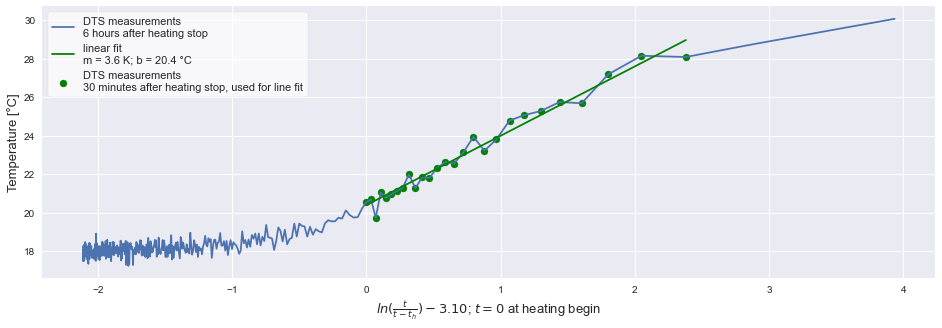

thermal conductvity from autoamtic linear fit: 0.21235543488610217 W/(Km)


In [4]:
# Input
depth=80 #80 230 change me
shift_dates_to_end_linear_fit=True

# some settings
offset=511
cable_length=offset+depth#about 100 depth: 612

# date ranges
dat=temp_sol[cable_length].iloc[1550:2600] # complete second heating phase
begin_end_sec_heat=["15.07.2021 16:18:30","16.07.2021 02:22:31"] # second heating phase, used in this notebook for calculations
begin_end_sec_heat_date=[pd.to_datetime(x) for x in begin_end_sec_heat]

date_name, end_heat_iloc=find_nearest_date(begin_end_sec_heat_date[1],dat.index)
date_name, end_heat30_iloc=find_nearest_date(begin_end_sec_heat_date[1]+timedelta(minutes=30),dat.index) #date 30 minutes after heat stop
date_name, end_heat6h_iloc=find_nearest_date(begin_end_sec_heat_date[1]+timedelta(hours=6),dat.index) #date 6 hours after heat stop
t_duration_heating=begin_end_sec_heat_date[1]-begin_end_sec_heat_date[0] # duration of this heating phase

# calc x values
t_30afterheatstop=dat.index[end_heat_iloc:end_heat30_iloc]-begin_end_sec_heat_date[0] # heating begin is t=0, only use first 30 minutes after heating stop
t=dat.index-begin_end_sec_heat_date[0]
x=np.log(t/(t-t_duration_heating))
x_30afterheatstop=np.log(t_30afterheatstop/(t_30afterheatstop-t_duration_heating))
t_6hafterheatstop=dat.index[end_heat_iloc:end_heat6h_iloc]-begin_end_sec_heat_date[0]
x_6hafterheatstop=np.log(t_6hafterheatstop/(t_6hafterheatstop-t_duration_heating))

#Plot
skip_val_for_linear_fit=3
if shift_dates_to_end_linear_fit==False:
    x_6_val=x_6hafterheatstop
    x_30_val=x_30afterheatstop[skip_val_for_linear_fit:]
elif shift_dates_to_end_linear_fit: # shift x axis, so line fit ends at y axis
    x_6_val=x_6hafterheatstop - x_30afterheatstop[-1]
    x_30_val=x_30afterheatstop[skip_val_for_linear_fit:]-x_30afterheatstop[-1]

ymin=15;ymax=30
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot(x_6_val, dat.values[end_heat_iloc:end_heat6h_iloc], label="DTS measurements\n6 hours after heating stop")
axs.scatter(x_30_val, dat.values[end_heat_iloc:end_heat30_iloc][skip_val_for_linear_fit:],color="green", 
        label="DTS measurements\n30 minutes after heating stop, used for line fit")

# Line fit
x_linefit=x_30_val
#manual
show_manual=False
if show_manual:
    b=18 #°C #enstpricht der ungestörten Temp
    m=0.1
    axs.plot(x_linefit,m*x_linefit+b,label="manual linear fit")
# automatic
mb=np.polyfit(x_linefit,dat.values[end_heat_iloc:end_heat30_iloc][skip_val_for_linear_fit:],1)
print(f"automatic line fit: m: {mb[0]}; b: {mb[1]}")
axs.plot(x_linefit,mb[0]*x_linefit+mb[1],color="green",
            label=f"linear fit\nm = {round(mb[0],1)} K; b = {round(mb[1],1)} °C")

# Assecoirs
axs.set_ylabel("Temperature [°C]",fontsize=13)
if shift_dates_to_end_linear_fit:
    if round(x_30afterheatstop[-1],2)!=3.1:
        print("!!!!adapt x axis description!!!!")
    axs.set_xlabel(r"$ln(\frac{t}{t-t_h})-3.10$; $t=0$ at heating begin",fontsize=13)
else:
    axs.set_xlabel(r"$ln(\frac{t}{t-t_h})$; $t=0$ at heating begin",fontsize=13)
legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)
if plot_save:
    if depth == 80 or depth==230:
        filename=f"\\egrt_calc_conductivity_{depth}"
        plt.savefig(r"pictures"+filename + ".png")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap3" +filename + ".pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap3" +filename + ".png", format="png",bbox_inches="tight",dpi=300)
plt.show()

# automatic fit thermal conductivity results
ql=4.81 *2 #[W/m] *2 because of cable up down
m=mb[0] #[K] #0.1
lamb=ql/(m*4*np.pi) #[W/(Km)]
print(f"thermal conductvity from autoamtic linear fit: {lamb} W/(Km)") 

In [5]:
# calculate lambda with manual values
ql=4.81 *2 #[W/m] *2 because of cable up down
m=2 #[K] #0.1
lamb=ql/(m*4*np.pi) #[W/(Km)]
lamb

0.3827676381360083